In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [39]:
# import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce

import aggfly
import netCDF4

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from aggfly import regions
from aggfly import dataset, regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator
# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()
# client = Client(n_workers=2)

project_dir = '/home3/dth2133/data/clim_data_requests/gio'

In [46]:
import os
import os.path

# Years to aggregate
years = np.arange(1951,2020)
years = years[years != 1959]

georegions = regions.from_path('../Data/usa_simple_noHI_id.shp', regionid='id')
georegions = georegions.sel(22)


<Axes: >

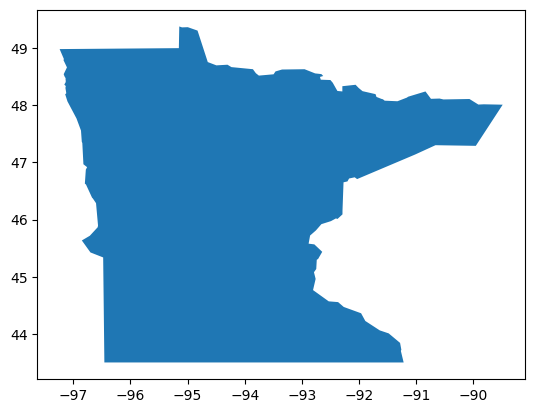

In [47]:
georegions.shp.plot()

In [48]:
secondary_weights = grid_weights.pop_weights.from_path(f'{project_dir}/gpw_v4_population_count_rev11_2000_2pt5_min.tif')

In [49]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"{project_dir}/era_06_2000_*.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)

In [51]:
# Calculate area and pop layer weights.
print("Loading weights")
weights = grid_weights.from_objects(
    clim,
    georegions,
    secondary_weights=secondary_weights,
    wtype=None,
    simplify=0.001)
weights.calculate_weights()

Loading weights
[########################################] | 100% Completed | 101.56 ms
[########################################] | 100% Completed | 102.15 ms
Rescaling pop weights to grid.
This might take a few minutes and use a lot of memory...
[########################################] | 100% Completed | 1.50 sms
[########################################] | 100% Completed | 1.60 s
Searching for border cells...
Negative buffer
[########################################] | 100% Completed | 105.11 ms
[########################################] | 100% Completed | 202.48 ms
[########################################] | 100% Completed | 1.34 sms
[########################################] | 100% Completed | 1.44 s
Positive buffer
[########################################] | 100% Completed | 102.56 ms
[########################################] | 100% Completed | 203.25 ms
[########################################] | 100% Completed | 1.31 sms
[########################################] | 100% C

In [ ]:
aggregate(
    aggregation = {
        'day': ['avg', 'max', 'min']
        'month': 'sum',
        'space': 'avg'
    }
    weights = weights,
    clim = clim
)

In [52]:
print("Scheduling aggregation")
daily = TemporalAggregator('avg', 'time.date')
monthly = TemporalAggregator('sum', 'time.month')

Scheduling aggregation


In [53]:
print('Aggregating')
day_ds = daily.map_execute(clim, weights)
month_ds = monthly.map_execute(day_ds, weights)

Aggregating


In [54]:
names = ['avg']
df = SpatialAggregator(month_ds, weights, names=names).compute()

COMPUTING
[########################################] | 100% Completed | 49.09 s
[########################################] | 100% Completed | 49.19 s
[########################################] | 100% Completed | 110.43 ms
[########################################] | 100% Completed | 209.25 ms


In [55]:
df

,region_id,time,avg
0,0,6,538.384493


In [35]:
# Clean output dataset and append
df = df.reset_index().rename(columns={'time':'month'})
df['year'] = 2000
df = df[['region_id', 'year', 'month'] + names]
df = georegions.shp[['id']].merge(df, left_index=True, right_on='region_id')

In [ ]:
df.reset_index().to_feather(f"{project_dir}/temp_data.feather")

<Axes: >

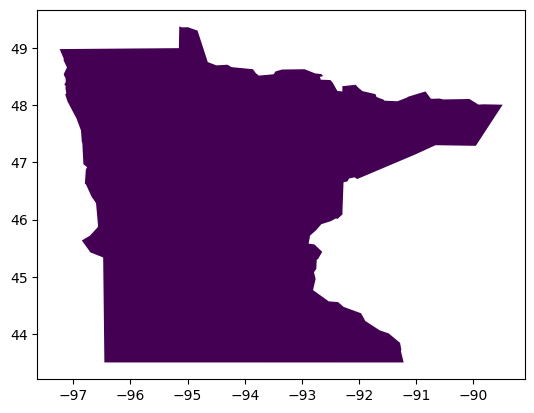

In [38]:
slc = df.loc[df.year==2000].groupby('id').mean()
georegions.shp.merge(slc, right_index=True, left_on='id').plot(column='avg')